# A METHODOLOGY FOR CONDUCTING DESIGN TRADES RELATED TO ADVANCED IN-SPACE ASSEMBLY
This notebook presents a simplified version of the method developped in my thesis. The full document is available [here](https://smartech.gatech.edu/handle/1853/60818). 
## In-Space Assembly and Methodology Overview

* **CONTEXT:** Ambitious efforts are underway to return astronauts to deep space, but technical and health challenges will require new types of systems with more advanced capabilities. In-Space Assembly (ISA) can enable these new systems by freeing designs from the size limitations of launch vehicles.
* **BACKGROUND:** ISA can be performed along a spectrum of complexity. Simpler methods deliver large pieces that require few assembly tasks, but are bulky to fit in launch vehicles. Advanced methods deliver smaller pieces packaged efficiently, but require more assembly tasks. There is a tradeoff between number of deliveries and time of assembly.
![ISA](isa.png)
* **PROBLEM:** The choice of assembly strategy impacts the cost and duration of the entire mission.  The effects of these design choices must be modeled together in order to conduct design trades. Different ISA methods can be used on different parts of a design.
* **SOLUTION:** The method presented employs a network formulation to model both delivery and assembly logistics. In this network, the pieces of a structure must flow from their initial state to a final assembly state, via arcs representing deliveries and assembly tasks. The network flow is optimized to minimize both the amount of deliveries required and the time of total assembly.

## Creating the delivery-assembly network
A single network models the delivery and assembly of a structure (such as a truss section in a large space station) with a number of pieces N that must be assembled sequentially. It consists of:
* a source node, with an "inflow" of value N
* a sink node, with an "inflow" of value -N
* intermediate state nodes, at each state between pre-delivery and completion, and at each time step in the time range
* arcs between these nodes, representing either delivery, storage, or assembly tasks.
    * Delivery arcs can link to various states, representing how advanced the assembly strategy chosen is
    * Assembly tasks link nodes at State S and time T to State S+1 and time T+(duration of the task)


### Input Settings
Before creating a network, let's declare some settings.

In [254]:
# the time range of the model
times = list(range(62))
# the number of pieces that must be delivered and assembled
number_of_pieces = 10
# the number of intermediate assembly states between delivery and completion
states = list(range(5))
# duration of assembly task required to progress to to next state
state_duration = [0,12,2,4,0]  
# states at which pieces can arrive from source, indicating complexity of ISA / efficiency of packaging
states_for_delivery = [1,2] 
# the frequency of the delivery methods
delivery_frequency= 15
# the cost of each delivery being used (regardless of how much it is filled)
cost_of_delivery = 1000
# number of pieces able to be carried in a single delivery, [to state 1, to state 2] for each delivery method
delivery_capacities = [6,3]
# number of pieces that can be stored in each state
state_storage_capacity = [0,6,4,4,0]
# number of pieces that can be assembled simultaneously from that state
state_assembly_capacity = [0,2,1,1,number_of_pieces]
# state origins where precedence is enforced, meaning the previous piece must be completed before another can begin
states_for_precedence = [2,3]  

### Generating network nodes

In [255]:
# nodes for each state and time step
nodes = [(s, t) for s in states for t in times if s > 0]
# add source
nodes.append((0, 0))
# add sink
nodes.append((max(states) + 1, max(times)))

#### Visualizing network nodes

Text(0, 0.5, 'State')

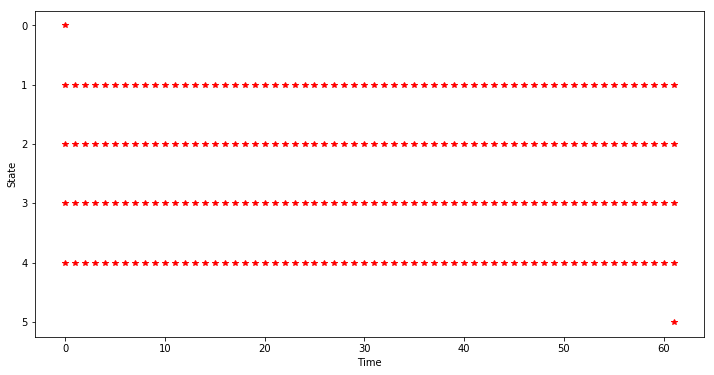

In [256]:
import matplotlib.pyplot as plt
%matplotlib inline
x_val = [x[0] for x in nodes]
y_val = [x[1] for x in nodes]
plt.figure(figsize=(12,6))
plt.gca().invert_yaxis()
plt.plot(y_val, x_val, 'r*')
plt.xlabel('Time')
plt.ylabel('State')

### Generating arcs between nodes

In [257]:
arcs = set()
number_of_deliveries = 0
# add delivery arcs
for i in range(len(times)):
    if i % delivery_frequency == 0:
        number_of_deliveries+=1
        for j in states_for_delivery:
            arcs.add(((0, 0), (j, i)))
            
arcs = list(arcs)
# create arcs across same state to t+1
arcs.extend([(n, (n[0], n[1] + 1)) for n in nodes if (n[1] + 1 in times and state_storage_capacity[n[0]]!=0)])

# add assembly task arcs between states with duration specified
for i, dur in enumerate(state_duration):
    arcs.extend([(n, (n[0] + 1, n[1] + dur)) for n in nodes if(n[0] == i and n[0] + 1 in states and n[1] + dur in times)])

# add arcs to sink
for n in nodes:
    if n[0] == max(states):
        arcs.append((n, (max(states) + 1, max(times))))       
arcs = list(set(arcs))

#### Visualizing arcs
We will use curves to be able to differentiate the two types of deliveries.

Text(0, 0.5, 'State')

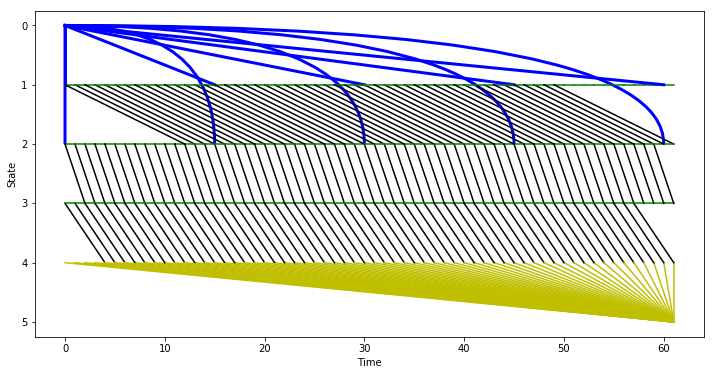

In [258]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def draw_curved_delivery(ori, dest, alpha=1):
    Path = mpath.Path
    pp = mpatches.PathPatch(
        Path([(ori[1], ori[0]), (dest[1], ori[0]), (dest[1], dest[0])],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3]),
        fc="none", transform=ax.transData, color='blue', ls='-', alpha=alpha, linewidth=3)
    return pp

fig, ax = plt.subplots(figsize=(12,6))
plt.gca().invert_yaxis()
# plt.plot(y_val, x_val, 'r*')

for ori,dest in arcs:
    if ori[0] == 0:
        if dest[0] == 1:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], color='blue', linewidth=3, label='Delivery')
        else:
            pp = draw_curved_delivery(ori, dest)
            ax.add_patch(pp)
    elif ori[0] == dest[0]:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'g', label='Storage')
    elif dest[0] == max(states) + 1:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'y', label='Sink')
    else:
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k', label='Assembly Task')

plt.xlabel('Time')
plt.ylabel('State')

* Blue arcs represent deliveries, which for the same day can occur at different states (deliver flat packed or in more advanced state)
* Green arcs represent storage, waiting further assembly by maintaining same state over time
* Black arcs represent assembly tasks, progressing the piece to the next state
* The yellow arcs simply collect all final state nodes to the sink

### Creating arc and node constraints
Each arc must have a maximum value limit
* delivery arcs depend on the delivery capacity and how advanced the state of assembly being delivered is
* storage arcs depend on the state and chosen storage capacity
* assembly tasks capacity should be 1 for sequential tasks, and a variable input for non sequential tasks (such as unpacking for example)

In [259]:
# arc constraints
arc_capacity = {}
for ori, dest in arcs:
    #  capacity of delivery arcs
    if ori[0]==0:
        for index, state in enumerate(states_for_delivery):
            if dest[0]== state:
                arc_capacity[(ori, dest)] = delivery_capacities[index]
                
    # capacity of storage arcs
    elif ori[0]==dest[0]:
        for index, state in enumerate(states):
            if ori[0]== state:
                arc_capacity[(ori, dest)] = state_storage_capacity[index]
                
    # capacity of assembly tasks
    else:
        for index, state in enumerate(states):
            if ori[0]== state:
                arc_capacity[(ori, dest)] = state_assembly_capacity[index]

# node constraints
node_inflow = {}
for n in nodes:
    node_inflow[n] = 0
node_inflow[(0, 0)] = number_of_pieces
node_inflow[(max(states) + 1, max(times))] = -number_of_pieces

## Building the optimization model
We will use the Pulp module for Python. The original thesis used the Gurobi commercial solver.

In [260]:
import pulp as plp
opt_model = plp.LpProblem(name="MIP Model")

arc_vars  = {(ori,dest):
plp.LpVariable(cat=plp.LpInteger, 
               lowBound=0, upBound=arc_capacity[(ori, dest)],
               name="arc_{0}_{1}".format(ori,dest)) 
for ori,dest in arcs}

delivery_used_vars  = {(d):
plp.LpVariable(cat=plp.LpInteger, 
               lowBound=0, upBound=1,
               name="delivery_used_{0}".format(d)) 
for d in range(number_of_deliveries)}

# network flow constraint, what flows in must flow out
for n in nodes:
    opt_model += plp.lpSum(arc_vars[ori,dest] for ori,dest in [a for a in arcs if a[1]==n]) + node_inflow[n] == plp.lpSum(arc_vars[ori,dest] for ori,dest in [a for a in arcs if a[0]==n]), "node_conservation_{}".format(n)
    
# precedence constraint, pieces must be assembled sequentially
for t in times:
    arcs_to_relate = [a for a in arcs if
                      ((a[0][0] in states_for_precedence and not a[1][0]==min(states_for_precedence) and a[0][1] <= t and a[1][1] > t))]
    opt_model += plp.lpSum(arc_vars[ori,dest] for ori,dest in arcs_to_relate) <=1, "precedence_{}".format(t)
    
# delivery capacity constraint, the deliveries cannot exceed their capacity by combining two types of delivery states
# also tracks delivery useage
d=0
for ori,dest in arcs:
    if ori[0]==0 and dest[0]==1:
        opt_model += plp.lpSum(arc_vars[ori,(state,dest[1])] * (1/delivery_capacities[index]) for index, state in enumerate(states_for_delivery)) <= delivery_used_vars[d], "delivery_cap{}".format(dest[1])
        d+=1
                
# minimize total assembly time by weighing the arcs to sink proportional to time
objective = plp.lpSum(arc_vars[ori,dest]*ori[1] for ori,dest in arcs if dest[0]==max(states)+1)
# minimize number of deliveries used
objective += plp.lpSum(delivery_used_vars[d]*cost_of_delivery for d in range(number_of_deliveries))

opt_model.sense = plp.LpMinimize
opt_model.setObjective(objective)
opt_model.writeLP("isa.lp")


## Obtaining a solution

In [261]:
opt_model.solve()
print("Status:", plp.LpStatus[opt_model.status])

Status: Optimal


## Plot solution

Delivery to state 2 at time 0 with 2.0 pieces
Delivery to state 1 at time 15 with 2.0 pieces
Delivery to state 1 at time 30 with 3.0 pieces
Delivery to state 1 at time 0 with 2.0 pieces
Delivery to state 2 at time 15 with 1.0 pieces


Text(0, 0.5, 'State')

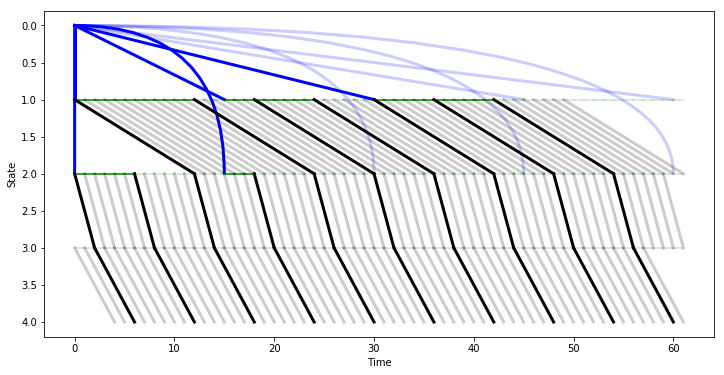

In [262]:
fig, ax = plt.subplots(figsize=(12,6))
plt.gca().invert_yaxis()

# Draw and Write down Deliveries
for ori,dest in arcs:
    # draw used arcs solid, unused arcs transparent
    if plp.value(arc_vars[ori,dest]) > 0:
        alpha = 1
    else:
        alpha = 0.2
    if ori[0] == 0:
        if dest[0] == 1:
            plt.plot([ori[1], dest[1]], [ori[0], dest[0]], alpha = alpha, color='blue', linewidth=3)
        else:
            pp = draw_curved_delivery(ori, dest, alpha)
            ax.add_patch(pp)
        if plp.value(arc_vars[ori,dest]) > 0:
            print('Delivery to state {} at time {} with {} pieces'.format(dest[0], dest[1], plp.value(arc_vars[ori,dest])))

# draw storages
for ori,dest in arcs:
    if ori[0]==dest[0]:
        # draw used arcs solid, unused arcs transparent
        if plp.value(arc_vars[ori,dest]) > 0:
            alpha = 1
        else:
            alpha = 0.2
            
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'g', alpha = alpha)
#         if plp.value(arc_vars[ori,dest]) > 0:
#             print('Storage from {} to {} with {} pieces'.format(ori, dest, plp.value(arc_vars[ori,dest])))
            
# draw assemblies
for ori,dest in arcs:
    if ori[0] != 0 and ori[0]!=dest[0] and dest[0]!=max(states)+1:
        # draw used arcs solid, unused arcs transparent
        if plp.value(arc_vars[ori,dest]) > 0:
            alpha = 1
        else:
            alpha = 0.2
            
        plt.plot([ori[1], dest[1]], [ori[0], dest[0]], 'k', alpha = alpha, linewidth=3)
#         if plp.value(arc_vars[ori,dest]) > 0:
#             print('Assembly from {} to {} with {} pieces'.format(ori, dest, plp.value(arc_vars[ori,dest])))

plt.xlabel('Time')
plt.ylabel('State')

We see the optimization model makes a first delivery at time 0 with 2 pieces in state 1 and 2 pieces in state 2. This allows the non-precedence task 1->2 (unpacking for example) to proceed simultaneously to the sequential assembly tasks for the more advanced pieces. 

This is repeated at time 15. Again the optimizer combines delivery under different states to be able to fit the entire assembly within the 62 time limit.

## Conclusion
These delivery-assembly networks can model the assembly of a structure consistent of pieces that must be assembled sequentially. The assembly of a whole system can be modeled by creating networks for each constituent structure of the large whole, and linking them by additional precedence constraints. This is done in the full document of the master's Thesis.